# Use CNN to Classify Air Quality


Imports

In [34]:
import os
import shutil
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Reshape, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

Data Preparation

In [35]:
src_base = 'img_src'
dst_base = 'aq_grouped'
err_img_path = 'image.png'

# Update label_map to include all folders you want to use
label_map = {
    'pm25_5': 'Good',
    'pm25_15': 'Moderate',
    'pm25_25': 'Moderate',
    'pm25_35': 'Bad',
    # Add more mappings if you have more folders
}

# Load error image in grayscale
err_img = cv2.imread(err_img_path)
err_img = cv2.cvtColor(err_img, cv2.COLOR_BGR2GRAY)

# Create destination folders
for label in set(label_map.values()):
    os.makedirs(os.path.join(dst_base, label), exist_ok=True)

# SSIM check (robust)
def is_error_image(img_color, err_img):
    try:
        img_gs = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    except Exception:
        return False
    if img_gs.shape != err_img.shape:
        img_gs = cv2.resize(img_gs, (err_img.shape[1], err_img.shape[0]))
    score, _ = ssim(img_gs, err_img, full=True)
    return score > 0.99  # Use a threshold

# Thread
def process_image(src_file, dst_file, label):
    filename = os.path.basename(src_file)
    try:
        img = cv2.imread(src_file)
        if img is None:
            return f"Skipped (unable to load): {filename}"
        if is_error_image(img, err_img):
            return f"Skipped (matches error image): {filename}"
        if not os.path.exists(dst_file):
            shutil.copy2(src_file, dst_file)
            return f"Copied: {filename} → {label}"
        else:
            return f"Skipped (already exists): {filename}"
    except Exception as e:
        return f"Error ({filename}): {e}"

In [33]:
# Move files (run once)
from concurrent.futures import ThreadPoolExecutor, as_completed
tasks = []
with ThreadPoolExecutor(max_workers=8) as executor:
    for src_folder, label in label_map.items():
        src_path = os.path.join(src_base, src_folder)
        dst_path = os.path.join(dst_base, label)
        if not os.path.exists(src_path):
            continue
        for filename in os.listdir(src_path):
            src_file = os.path.join(src_path, filename)
            dst_file = os.path.join(dst_path, filename)
            tasks.append(executor.submit(process_image, src_file, dst_file, label))
    for future in as_completed(tasks):
        print(future.result())

Skipped (matches error image): 2021-10-12T19_00_36+00_00.jpg
Skipped (already exists): 2021-11-01T19_53_13+00_00.jpg
Skipped (already exists): 2021-10-14T16_24_20+00_00.jpg
Skipped (already exists): 2021-11-01T18_31_43+00_00.jpg
Skipped (already exists): 2021-10-11T19_16_00+00_00.jpg
Skipped (matches error image): 2021-10-12T17_50_34+00_00.jpg
Skipped (already exists): 2021-10-31T21_28_25+00_00.jpg
Skipped (already exists): 2021-10-26T21_50_17+00_00.jpg
Skipped (already exists): 2021-10-26T16_38_35+00_00.jpg
Skipped (already exists): 2021-10-23T18_16_46+00_00.jpg
Skipped (already exists): 2021-11-03T18_49_59+00_00.jpg
Skipped (already exists): 2021-10-22T22_02_26+00_00.jpg
Skipped (already exists): 2021-10-21T22_24_24+00_00.jpg
Skipped (already exists): 2021-10-18T18_53_04+00_00.jpg
Skipped (already exists): 2021-10-09T20_10_07+00_00.jpg
Skipped (already exists): 2021-11-04T20_41_37+00_00.jpg
Skipped (matches error image): 2021-10-10T19_28_59+00_00.jpg
Skipped (already exists): 2021-10

Data Generators

In [8]:
image_size = (224, 224)
batch_size = 32
data_dir = dst_base

def crop_top(img, crop_ratio=0.7):
    """
    Crops the top crop_ratio portion of the image.
    img: numpy array with shape (height, width, channels), values in [0, 255] or [0, 1]
    crop_ratio: float, fraction of the image height to keep from the top
    Returns an image of the same size, with the bottom part blacked out.
    """
    import numpy as np
    h = img.shape[0]
    crop_h = int(h * crop_ratio)
    mask = np.zeros_like(img)
    mask[:crop_h, :, :] = img[:crop_h, :, :]
    return mask

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    shear_range=2,
    horizontal_flip=True,
    fill_mode='nearest',
    # preprocessing_function=crop_top  # <--- add this line
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    # preprocessing_function=crop_top  # <--- add this line
)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)
val_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)

Found 4144 images belonging to 3 classes.
Found 1036 images belonging to 3 classes.
Class indices: {'Bad': 0, 'Good': 1, 'Moderate': 2}


Class weights: {0: np.float64(3.635087719298246), 1: np.float64(1.113978494623656), 2: np.float64(0.5472794506075013)}


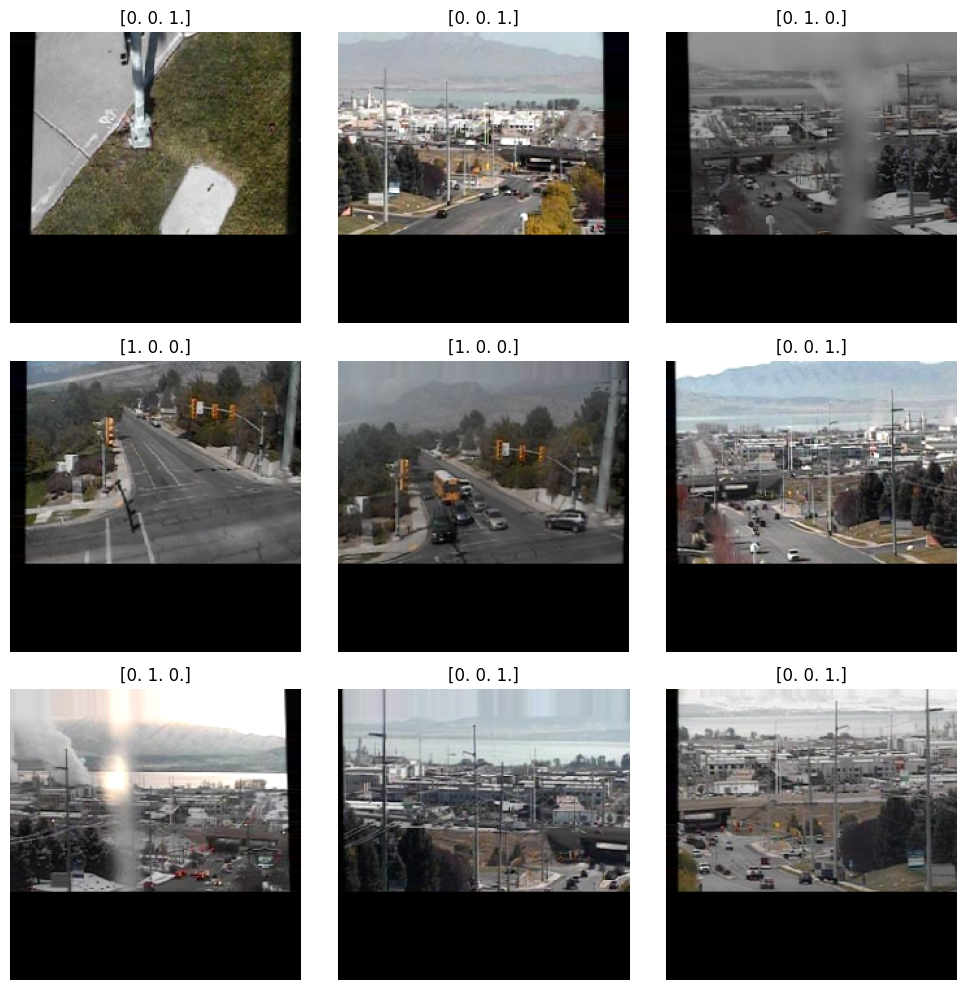

Class indices: {'Bad': 0, 'Good': 1, 'Moderate': 2}


In [9]:
# --- Class Weights ---
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# --- CLAHE (optional) ---
# def apply_clahe(img):
#     img = (img * 255).astype(np.uint8)
#     lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
#     l, a, b = cv2.split(lab)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     cl = clahe.apply(l)
#     limg = cv2.merge((cl,a,b))
#     enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
#     return enhanced_img / 255.0

# --- Batch Visualization ---
images, label = next(train_generator)
# images_clahe = np.array([apply_clahe(img) for img in images])
batch_size = images.shape[0]
plt.figure(figsize=(10, 10))
for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow((images_clahe[i] * 255).astype("uint8"))
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(str(label[i]))
    plt.axis("off")
plt.tight_layout()
plt.show()

# Add class indices
print("Class indices:", train_generator.class_indices)

Model Definition

In [10]:
# # --- Squeeze-and-Excitation (SE) block ---
# def se_block(input_tensor, ratio=8):
#     channel_axis = -1
#     filters = int(input_tensor.shape[channel_axis])
#     se_shape = (1, 1, filters)

#     se = GlobalAveragePooling2D()(input_tensor)
#     se = Reshape(se_shape)(se)
#     se = Dense(max(filters // ratio, 1), activation='relu', use_bias=False)(se)
#     se = Dense(filters, activation='sigmoid', use_bias=False)(se)
#     x = multiply([input_tensor, se])
#     return x

# # --- CNN model with SE blocks ---
# inputs = Input(shape=(150, 150, 3))

# x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
# x = BatchNormalization()(x)
# x = se_block(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.2)(x)

# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = se_block(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.3)(x)

# x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = se_block(x)
# x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.4)(x)

# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.6)(x)
# outputs = Dense(3, activation='softmax')(x)  # 3 classes: Good / Moderate / Bad

# model = Model(inputs, outputs)
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

# --- Optional: Updated CNN Model ---
# img_height, img_width = 224, 224
# num_classes = len(train_generator.class_indices)
# from tensorflow.keras import layers, Sequential

# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)input_img = Input(shape=(150, 150, 3))
# ])

# # --- Updated CNN Model ---
# inputs = Input(shape=(224, 224, 3))

# # Layer 1
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)  # Depth = 16
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.5)(x)  # Dropout rate = 0.5

# # Layer 2
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.5)(x)

# # Layer 3
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.5)(x)

# # Global Pooling and Dense Layers
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)
# outputs = Dense(3, activation='softmax')(x)  # 3 classes: Good / Moderate / Bad

# model = Model(inputs, outputs)

# Compile the model
# model.compile(optimizer='adam',
#               loss = tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])

# model.summary()



In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Input layer
input_img = Input(shape=(224, 224, 3))

# Preprocessing and base model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_img)

# Freeze base layers (optional at first)
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=input_img, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,926 (16.07 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Training

In [13]:
from tensorflow.keras.models import Model as TFModel

# … after model.fit(…) …
# build multi‐scale feature extractor with the real layer names:
feat1 = model.get_layer('block6d_add').output          # last “add” in the conv blocks
feat2 = model.get_layer('global_average_pooling2d_3').output  # your head’s GAP layer
multi_feat_model = TFModel(inputs=model.input, outputs=[feat1, feat2])

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        mode='min',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
        mode='min',
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    # callbacks=callbacks,
    class_weight=class_weights_dict
)


/home/jasonrao/Documents/TCAM/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1748536507.703051   57888 service.cc:152] XLA service 0x773c8404d7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748536507.703101   57888 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2025-05-29 10:35:07.882109: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748536508.923447   57888 cuda_dnn.cc:529] Loaded cuDNN version 90501


  1/130 ━━━━━━━━━━━━━━━━━━━━ 24:30 11s/step - accuracy: 0.3750 - loss: 1.2734

I0000 00:00:1748536515.173316   57888 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.3350 - loss: 1.1348

2025-05-29 10:35:49.486577: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2076', 204 bytes spill stores, 204 bytes spill loads

2025-05-29 10:35:49.532739: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2076_0', 464 bytes spill stores, 1372 bytes spill loads

2025-05-29 10:35:49.739904: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2076', 5616 bytes spill stores, 5612 bytes spill loads

2025-05-29 10:35:49.918092: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2076', 5340 bytes spill stores, 5324 bytes spill loads

2025-05-29 10:35:53.59861

130/130 ━━━━━━━━━━━━━━━━━━━━ 53s 325ms/step - accuracy: 0.3350 - loss: 1.1347 - val_accuracy: 0.5434 - val_loss: 1.0974
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.3424 - loss: 1.1018 - val_accuracy: 0.2992 - val_loss: 1.1006
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step - accuracy: 0.3075 - loss: 1.1387 - val_accuracy: 0.2992 - val_loss: 1.0974
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - accuracy: 0.2949 - loss: 1.1246 - val_accuracy: 0.6091 - val_loss: 1.0901
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 199ms/step - accuracy: 0.3399 - loss: 1.1279 - val_accuracy: 0.2992 - val_loss: 1.1015
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 199ms/step - accuracy: 0.3341 - loss: 1.0948 - val_accuracy: 0.0917 - val_loss: 1.1131
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 198ms/step - accuracy: 0.3153 - loss: 1.1002 - val_accuracy: 0.6091 - val_loss: 1.0913
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 199ms/step - accuracy: 0.3542 - loss: 1.0965 - val

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step


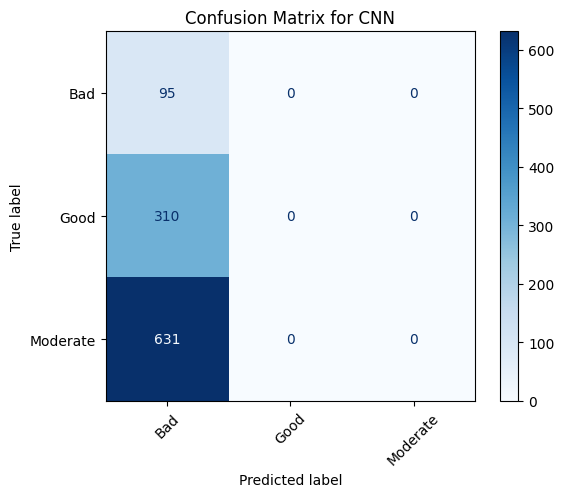

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on validation data
y_val_true = val_generator.classes  # True labels
y_val_pred = model.predict(val_generator)  # Predicted probabilities
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class indices

# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for CNN")
plt.show()

Random Forest on CNN Features

In [18]:
import numpy as np

def extract_features_labels(generator, model):
    """
    Runs generator through `model` to extract features, returns
    X: (num_samples, feat_dim), y: (num_samples,)
    """
    feats, labs = [], []
    steps = int(np.ceil(generator.samples / generator.batch_size))
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        out = model.predict(x_batch)
        # flatten/concatenate if multiple outputs
        if isinstance(out, list):
            flat = [o.reshape(o.shape[0], -1) for o in out]
            out = np.concatenate(flat, axis=1)
        else:
            out = out.reshape(out.shape[0], -1)
        feats.append(out)
        labs.append(np.argmax(y_batch, axis=1))
    X = np.vstack(feats)
    y = np.hstack(labs)
    return X, y

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Extract CNN features as before
feature_extractor = multi_feat_model
X_train, y_train = extract_features_labels(train_generator, feature_extractor)
X_val,   y_val   = extract_features_labels(val_generator,   feature_extractor)

# 1.5 – Hyperparameter tuning via RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    params,
    cv=3,
    n_iter=10,
    verbose=2,
    n_jobs=-1
)
search.fit(X_train, y_train)
print("Best RF params:", search.best_params_)

# 2. Train RF regressor with best params
rf_reg = search.best_estimator_
rf_reg.fit(X_train, y_train)

# 3. Evaluate on validation set
y_pred = rf_reg.predict(X_val)
print("RMSE:", mean_squared_error(y_val, y_pred, squared=False))
print("MAE: ", mean_absolute_error(y_val, y_pred))
# filepath: /home/jasonrao/Documents/TCAM/cnn.ipynb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Extract CNN features as before
feature_extractor = multi_feat_model
X_train, y_train = extract_features_labels(train_generator, feature_extractor)
X_val,   y_val   = extract_features_labels(val_generator,   feature_extractor)

# 1.5 – Hyperparameter tuning via RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    params,
    cv=3,
    n_iter=10,
    verbose=2,
    n_jobs=-1
)
search.fit(X_train, y_train)
print("Best RF params:", search.best_params_)

# 2. Train RF regressor with best params
rf_reg = search.best_estimator_
rf_reg.fit(X_train, y_train)

# 3. Evaluate on validation set
y_pred = rf_reg.predict(X_val)
print("RMSE:", mean_squared_error(y_val, y_pred, squared=False))
print("MAE: ", mean_absolute_error(y_val, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

KeyboardInterrupt: 

Feature Map Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


/home/jasonrao/Documents/TCAM/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_729']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


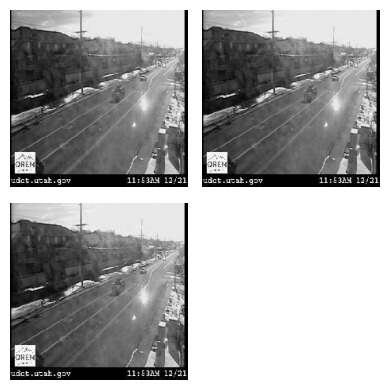

In [27]:
file_test = 'aq_grouped/Moderate/2021-12-21T18_53_17+00_00.jpg'

from numpy import expand_dims
img = load_img(file_test, target_size=(224, 224))
img = img_to_array(img)
img = expand_dims(img, axis=0)
feature_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
feature_maps = feature_model.predict(img)
n_filters = feature_maps.shape[-1]
grid_size = int(np.ceil(np.sqrt(n_filters)))
plt.figure(figsize=(grid_size * 2, grid_size * 2))
for i in range(n_filters):
    ax = plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

0 input_layer_3 InputLayer
1 rescaling_6 Rescaling
2 normalization_3 Normalization
3 rescaling_7 Rescaling
4 stem_conv_pad ZeroPadding2D
5 stem_conv Conv2D
6 stem_bn BatchNormalization
7 stem_activation Activation
8 block1a_dwconv DepthwiseConv2D
9 block1a_bn BatchNormalization
10 block1a_activation Activation
11 block1a_se_squeeze GlobalAveragePooling2D
12 block1a_se_reshape Reshape
13 block1a_se_reduce Conv2D
14 block1a_se_expand Conv2D
15 block1a_se_excite Multiply
16 block1a_project_conv Conv2D
17 block1a_project_bn BatchNormalization
18 block2a_expand_conv Conv2D
19 block2a_expand_bn BatchNormalization
20 block2a_expand_activation Activation
21 block2a_dwconv_pad ZeroPadding2D
22 block2a_dwconv DepthwiseConv2D
23 block2a_bn BatchNormalization
24 block2a_activation Activation
25 block2a_se_squeeze GlobalAveragePooling2D
26 block2a_se_reshape Reshape
27 block2a_se_reduce Conv2D
28 block2a_se_expand Conv2D
29 block2a_se_excite Multiply
30 block2a_project_conv Conv2D
31 block2a_projec

/home/jasonrao/Documents/TCAM/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_729']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


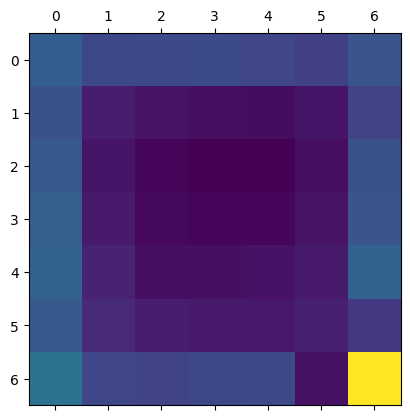

In [28]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Print all layer names to find the last Conv2D layer
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.__class__.__name__)

# Use the correct last Conv2D layer name (update if needed)
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, Conv2D):
        last_conv_layer_name = layer.name
        break
print("Last Conv2D layer:", last_conv_layer_name)

# Preprocess image for Grad-CAM (with or without CLAHE, match your training)
img = load_img(file_test, target_size=(224, 224))
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = img / 255.0
# img = np.array([apply_clahe(img[0])])  # Remove this line if you did NOT use CLAHE in training

heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name=last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

Target Conv2D layer for Grad-CAM: stem_conv


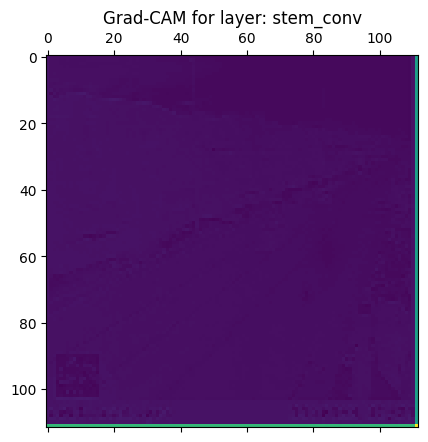

In [29]:
# --- Grad-CAM for a specific Conv2D layer ---
target_conv_layer_name = None
for layer in model.layers:
    if isinstance(layer, Conv2D):
        target_conv_layer_name = layer.name
        break
print("Target Conv2D layer for Grad-CAM:", target_conv_layer_name)

img = load_img(file_test, target_size=(224, 224))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name=target_conv_layer_name)

plt.matshow(heatmap)
plt.title(f"Grad-CAM for layer: {target_conv_layer_name}")
plt.show()